In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -r requirements.txt

In [ ]:
import os

target_dir = "../"
zip_file_path = "generated.zip"

if not os.path.exists(target_dir + 'generated'):
    print(f"The directory {target_dir} does not exist. Proceeding with download.")

    !apt-get update
    !apt-get install unzip
    
    !curl "https://drive.usercontent.google.com/download?id=1q-UsGAekgUFdGgj40sCuCWW8d8bRuIA6&confirm=xxx" -o {zip_file_path}
    !mkdir -p {target_dir}
    
    !unzip {zip_file_path} -d {target_dir}
    
    print(f"File downloaded and extracted to {target_dir}")
    
    !rm {zip_file_path}
else:
    print(f"The directory {target_dir} already exists. No action taken.")

The directory ../ already exists. No action taken.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os
import wandb
import matplotlib.pyplot as plt
import torch.profiler
import h5py
from tqdm import tqdm
from datetime import datetime
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from model import AuctionPredictor
from auction_dataset import AuctionDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
pairs = pd.read_csv('../generated/auction_indices.csv')
pairs.head()

,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
0,2024-01-04 00:00:00,12365,173,11.87,8.41,0.0,44.0,wotlk
1,2024-01-04 00:00:00,7462,1,11.00,0.00,11.0,11.0,wotlk
2,2024-01-04 00:00:00,20950,63,9.59,7.13,2.0,17.0,wotlk
3,2024-01-04 00:00:00,9681,23,19.17,10.96,1.0,47.0,wotlk
4,2024-01-04 00:00:00,36907,947,14.43,4.82,0.0,45.0,wotlk


## Prepare and balance data

In [5]:
pd.options.display.float_format = '{:.2f}'.format
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00,12556735.00
mean,25211.34,14.34,17.20,5.73,10.38,26.31
std,17112.51,54.68,13.18,6.00,14.07,16.36
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10184.00,1.00,9.00,0.00,1.00,14.00
50%,23782.00,3.00,14.67,4.71,6.00,24.00
75%,39909.00,8.00,22.12,9.89,14.00,39.00
max,232031.00,5008.00,164.00,80.00,164.00,164.00


In [6]:
pairs[['group_len']].quantile(0.99)

group_len   212.00
Name: 0.99, dtype: float64

In [7]:
pairs = pairs[pairs['group_max'] <= 50]
pairs.describe()

,item_id,group_len,group_mean,group_std,group_min,group_max
count,12411936.00,12411936.00,12411936.00,12411936.00,12411936.00,12411936.00
mean,25086.82,14.46,16.36,5.71,9.55,25.47
std,17053.05,54.98,10.28,5.67,11.13,14.12
min,35.00,1.00,0.00,0.00,0.00,0.00
25%,10175.00,1.00,8.92,0.00,1.00,14.00
50%,23627.00,3.00,14.50,4.78,5.00,24.00
75%,39469.00,9.00,22.00,9.91,14.00,38.00
max,232031.00,5008.00,50.00,25.00,50.00,50.00


In [31]:
train_pairs, val_pairs = train_test_split(pairs, test_size=0.05, random_state=42, shuffle=False)

print(f"Before filtering: {len(train_pairs)}")

train_pairs = train_pairs[train_pairs['group_len'] < 64]

print(f"After filtering: {len(train_pairs)}\n")

print(f"Train pairs: {len(train_pairs)}")
print(f"Val pairs: {len(val_pairs)}")

Before filtering: 11791339
After filtering: 11297543

Train pairs: 11297543
Val pairs: 620597


In [32]:
train_pairs.sample(5)

,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
1303820,2024-01-11 02:00:00,1652,1,20.00,0.00,20.00,20.00,wotlk
6460096,2024-02-10 07:00:00,43666,2,5.50,5.50,0.00,11.00,wotlk
7915259,2024-02-18 06:00:00,25676,37,15.51,4.49,1.00,19.00,wotlk
4527258,2024-01-31 04:00:00,10088,1,15.00,0.00,15.00,15.00,wotlk
8098431,2024-02-19 05:00:00,21872,1,0.00,0.00,0.00,0.00,wotlk


In [33]:
val_pairs.sample(5)

,record,item_id,group_len,group_mean,group_std,group_min,group_max,expansion
12414748,2024-09-19 11:00:00,56481,2,14.50,10.50,4.00,25.00,cata
12276772,2024-09-12 06:00:00,38938,1,43.00,0.00,43.00,43.00,cata
12068423,2024-09-06 11:00:00,38437,1,3.00,0.00,3.00,3.00,cata
12450836,2024-09-20 15:00:00,42958,16,21.44,12.69,0.00,48.00,cata
12301208,2024-09-12 23:00:00,52783,1,9.00,0.00,9.00,9.00,cata


expansion
wotlk    9540310
cata     1757233
Name: count, dtype: int64


<Axes: xlabel='expansion'>

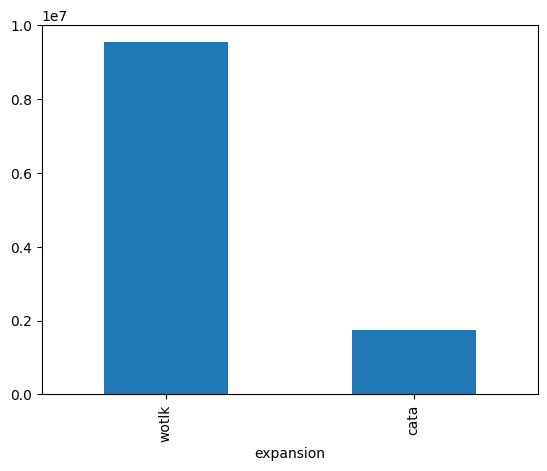

In [34]:
undersample_expansion = False

if undersample_expansion:
    print(f"Under-sampling expansion")
    train_pairs_wotlk = train_pairs[train_pairs['expansion'] == 'wotlk']

    rows_to_delete = train_pairs_wotlk.sample(n=int(len(train_pairs_wotlk) * 0.85)).index
    train_pairs = train_pairs.drop(rows_to_delete)

print(train_pairs.expansion.value_counts())
train_pairs.expansion.value_counts().plot(kind='bar')

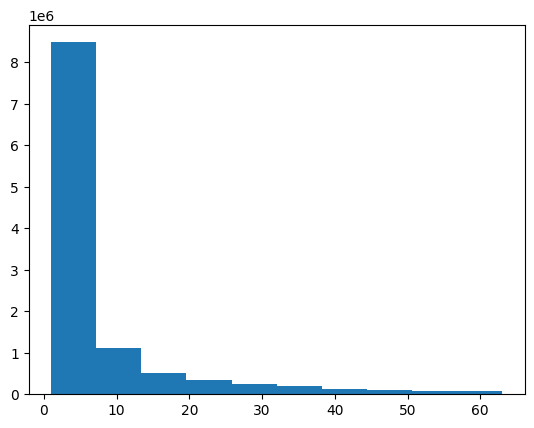

In [35]:
plt.hist(train_pairs['group_len'], bins=10)
plt.show()

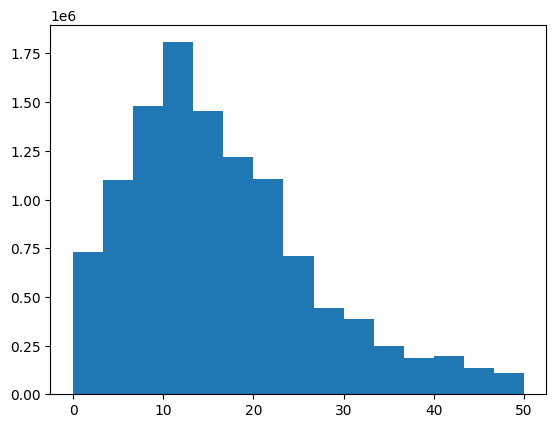

In [36]:
plt.hist(train_pairs['group_mean'], bins=15)
plt.show()

We undersample the hours_on_sale variable. In some previous experiments, we noticed that the model was better predicting low values. To make the model more robust, we want to have more high values in the training dataset

<Axes: xlabel='hours_cat'>

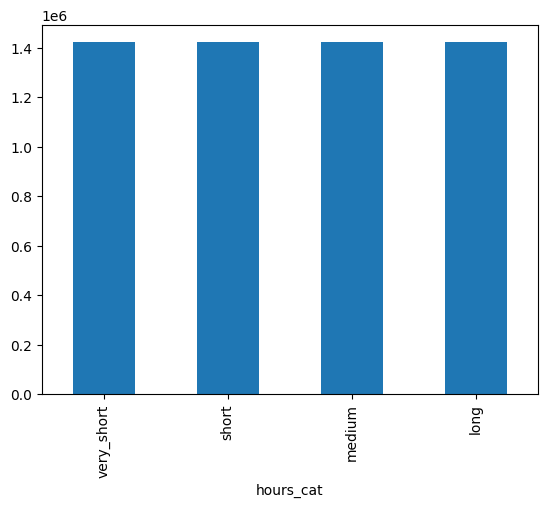

In [39]:
train_pairs["hours_cat"] = pd.cut(train_pairs["group_mean"], bins=[0., 12.0, 20.0, 25.0, np.inf], labels=['very_short', 'short', 'medium', 'long'])
train_pairs["hours_cat"].value_counts().plot(kind='bar')

In [38]:
min_samples = train_pairs["hours_cat"].value_counts().min()

train_pairs = pd.concat([
    train_pairs[train_pairs["hours_cat"] == cat].sample(n=min_samples, random_state=42, replace=False) 
    for cat in ['very_short', 'short', 'medium', 'long']
])

print(f"Train pairs: {len(train_pairs)} (after filtering)")

Train pairs: 5686252 (after filtering)


In [ ]:
items = pd.read_csv('../data/items.csv')
n_items = len(items)

item_to_index = {item_id: i + 2 for i, item_id in enumerate(items['item_id'])}
item_to_index[0] = 0 # padding
item_to_index[1] = 1 # unknown
n_items

In [ ]:
def collate_auctions(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    X, y = zip(*batch)

    lengths = torch.LongTensor([x.size(0) for x in X])

    max_length = lengths.max()

    X = [F.pad(x, (0, 0, 0, max_length - x.size(0))) for x in X]
    y = [F.pad(x, (0, max_length - x.size(0))) for x in y]

    X = torch.stack(X)
    y = torch.stack(y)

    return X, y, lengths

## Model definition

In [ ]:
embedding_size = 1024
encoder_hidden_size = 2048
decoder_hidden_size = 2048
dropout = 0.2
bidirectional = False
num_layers = 3
batch_size = 128
n_items = len(item_to_index)

model = AuctionPredictor(n_items,
                         input_size=5,
                         encoder_hidden_size=encoder_hidden_size,
                         decoder_hidden_size=decoder_hidden_size,
                         num_layers=num_layers,
                         item_index=3,
                         embedding_size=embedding_size,
                         dropout_p=dropout,
                         bidirectional=bidirectional
                         ).to(device)

print(sum(p.numel() for p in model.parameters()))

In [ ]:
load_checkpoint = False

if load_checkpoint:
  checkpoint = torch.load('checkpoints/checkpoint_epoch_4.pt')
  model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
train_dataset = AuctionDataset(train_pairs, item_to_index, path='../generated/sequences.h5')
val_dataset = AuctionDataset(val_pairs, item_to_index, path='../generated/sequences.h5')

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=8, prefetch_factor=2, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_auctions, num_workers=8, prefetch_factor=2, pin_memory=True)

In [ ]:
test_data_loader = False

if test_data_loader:
    iter_loader = iter(train_dataloader)
    X, y, lengths = next(iter_loader)

    print(X.shape)
    print(y.shape)
    print(lengths.shape)

    print(X.dtype)
    print(y.dtype)
    print(lengths.dtype)

In [ ]:
epochs = 3
eval_steps = 2500
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
total_steps = len(train_dataloader) * epochs
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, verbose=True)
criterion = nn.MSELoss(reduction='sum')

print(f'Iterations per epoch: {len(train_dataloader)}')

In [ ]:
enable_logging = False

if enable_logging:
  print("Logging enabled")
  wandb.init(project="auction-classic", config={
      "epochs": epochs,
      "batch_size": train_dataloader.batch_size,
      "learning_rate": optimizer.param_groups[0]['lr'],
      "encoder_hidden_size": encoder_hidden_size,
      "decoder_hidden_size": decoder_hidden_size,
      "model_size": sum(p.numel() for p in model.parameters()),
      "embedding_size": embedding_size,
      "bidirectional": bidirectional,
      "dropout": dropout,
      "num_layers": num_layers,
      "batch_size": batch_size,
  })
else:
  print("Logging disabled")
  wandb.init(mode="disabled")

## Training

In [ ]:
from train import train

train(
  model,
  train_dataloader,
  val_dataloader,
  epochs,
  eval_steps=eval_steps,
  device=device,
  optimizer=optimizer,
  criterion=criterion,
  lr_scheduler=lr_scheduler
)